In [40]:
import os, sys
from itertools import cycle
import json
import contextily as cx
from matplotlib import pyplot as plt
from PIL import Image
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from xml.etree import ElementTree as ET
import numpy as np

In [2]:
from sumobin import run_net2geojson

In [9]:
def _net_to_gdf(net_file: str):
    tree = ET.parse(net_file)
    root = tree.getroot()
    location = root.find("location")
    if not location:
        location = ET.Element("location")
        location.attrib["netOffset"] = "0,0"
        location.attrib["convBoundary"] = "0,0,3000,3000"
        location.attrib["origBoundary"] = "0,0,3000,3000"
        root.append(location)
    if "projParameter" not in location.attrib or location.attrib["projParameter"] == "!":
        location.attrib["projParameter"] = "+proj=utm +zone=32 +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    tree.write(net_file)

    name = os.path.basename(net_file).replace('.net.xml', '')
    geo_json_path = os.path.join("../data", f"{name}.geo.json")
    try:
        run_net2geojson(net_file, geo_json_path, ['--junctions'])
    except:
        print("[ERR] Network doesn't provide geo json representation, cannot save image...", file=sys.stderr)
        return None, True
    
    gdf: gpd.GeoDataFrame = gpd.read_file(geo_json_path)

    return gdf

def load(id: int):
    return _net_to_gdf(f"../data/part{id}.net.xml")

In [10]:
gdf0 = load(0)

Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part0.net.xml --output ../data/part0.geo.json --junctions


In [11]:
gdf0

,element,id,name,geometry
0,edge,-1032084995,Vicolo San Damiano,"LINESTRING (4.51544 0.01065, 4.51557 0.01065, ..."
1,edge,-1098811210,Via Belmeloro,"LINESTRING (4.52035 0.01580, 4.52042 0.01576, ..."
2,edge,-152026709,Vicolo De&apos; Facchini,"LINESTRING (4.51788 0.01635, 4.51779 0.01641, ..."
3,edge,-23271660,Piazza San Michele,"LINESTRING (4.51785 0.01306, 4.51788 0.01310, ..."
4,edge,-236470544#2,Piazza Giosuè Carducci,"LINESTRING (4.52329 0.00834, 4.52331 0.00835, ..."
...,...,...,...,...
213,junction,251845011,None,"LINESTRING (4.51745 0.01550, 4.51746 0.01548, ..."
214,junction,250763104,None,"LINESTRING (4.51350 0.01742, 4.51350 0.01740)"
215,junction,386057373,None,"LINESTRING (4.52093 0.00688, 4.52095 0.00689)"
216,junction,343434263,None,"LINESTRING (4.51602 0.01023, 4.51605 0.01024)"


In [13]:
gdfs = [load(i) for i in range(6)]

Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part0.net.xml --output ../data/part0.geo.json --junctions
Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part1.net.xml --output ../data/part1.geo.json --junctions
Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part2.net.xml --output ../data/part2.geo.json --junctions
Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part3.net.xml --output ../data/part3.geo.json --junctions
Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python /home/filippo/repos/sumo/tools/net/net2geojson.py --net-file ../data/part4.net.xml --output ../data/part4.geo.json --junctions
Executing /home/filippo/tesim/Parallel-Sumo/.venv/bin/python

In [14]:
for i, gdf in enumerate(gdfs):
    gdf["partitions"] = i

In [75]:
result_gdf = pd.concat(gdfs, ignore_index=True)
result_gdf = result_gdf.groupby('id') \
    .agg({'partitions': tuple, **{col: 'first' for col in result_gdf.columns if col != 'partitions' and col != 'id'}}) \
    .reset_index()
result_gdf = gpd.GeoDataFrame(result_gdf, geometry="geometry")
result_gdf

,id,partitions,element,name,geometry
0,-1032084995,"(0,)",edge,Vicolo San Damiano,"LINESTRING (4.51544 0.01065, 4.51557 0.01065, ..."
1,-1070362289#1,"(4,)",edge,Via Irnerio,"LINESTRING (4.51753 0.01995, 4.51754 0.01995, ..."
2,-1098811210,"(0,)",edge,Via Belmeloro,"LINESTRING (4.52035 0.01580, 4.52042 0.01576, ..."
3,-1116253887#1,"(1,)",edge,Via Giuseppe Mazzini,"LINESTRING (4.53024 0.00689, 4.53027 0.00687, ..."
4,-1116253888,"(1,)",edge,Via Giuseppe Mazzini,"LINESTRING (4.53110 0.00645, 4.53139 0.00631)"
...,...,...,...,...,...
1320,cluster_359971536_359971547_6344642501,"(1, 2)",junction,None,"LINESTRING (4.52410 0.00750, 4.52409 0.00756, ..."
1321,cluster_361564583_3799407578_3821594492,"(4,)",junction,None,"LINESTRING (4.52324 0.01657, 4.52299 0.01655, ..."
1322,cluster_365178425_386051885,"(1,)",junction,None,"LINESTRING (4.52684 0.00733, 4.52695 0.00728, ..."
1323,cluster_370949181_370949183_6905234460,"(2, 4)",junction,None,"LINESTRING (4.52394 0.01022, 4.52371 0.01020, ..."


In [76]:
result_gdf["partitions"].unique()

array([(0,), (4,), (1,), (2,), (1, 2), (3,), (5,), (0, 2), (3, 5), (0, 4),
       (4, 5), (1, 5), (2, 4), (0, 2, 4, 5)], dtype=object)

In [98]:
from shapely.ops import transform

def offset_downwards(geometry, offset):
  return transform(lambda x, y: (x, y - offset), geometry)

# Create a colormap
cmap = plt.cm.tab10

# Create a dictionary to map partition IDs to colors
partition_colors = {}
for i in range(6):
    partition_colors[i] = cmap(i)

offset = 0.01
exploded_rows = []

for index, row in result_gdf.iterrows():
  # Get the geometry and partitions for the current row.
  geometry = row['geometry']
  partitions = row['partitions']

  # Create a new row for each partition.
  for partition in partitions:
    new_row = {'id': row['id'], 'geometry': geometry, 'partitions': partition, 'color': partition_colors[partition]}
    geometry = offset_downwards(geometry, offset)
    exploded_rows.append(new_row)
    
exploded_gdf = gpd.GeoDataFrame(exploded_rows)

<Axes: >

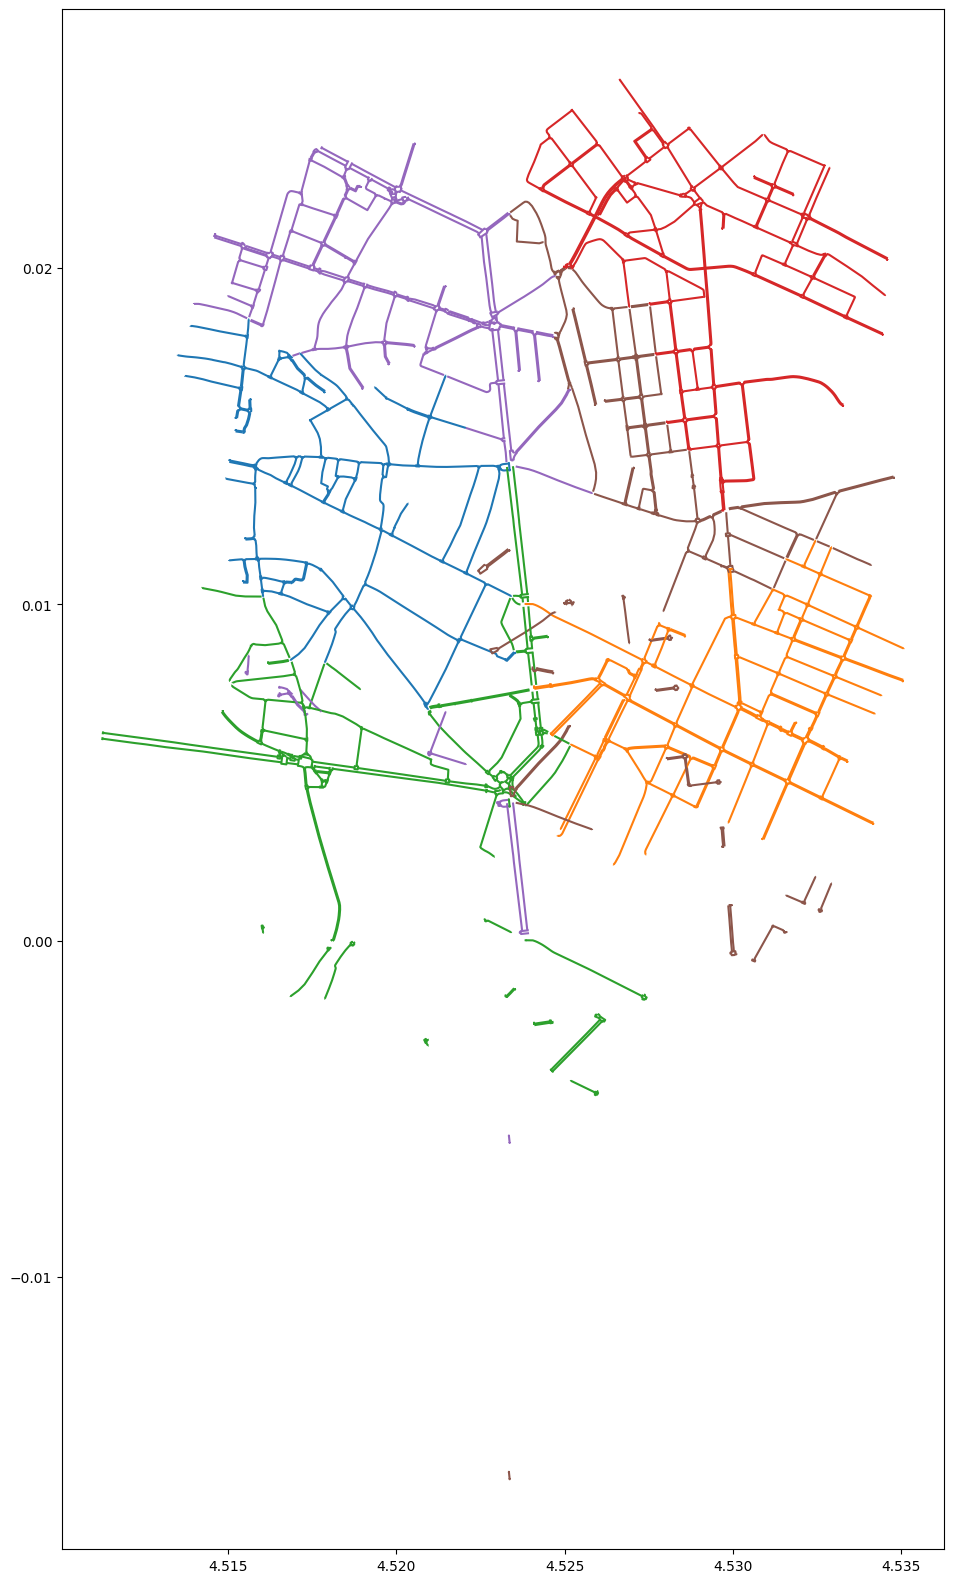

In [99]:
exploded_gdf.plot(color=exploded_gdf["color"], figsize=(20,20))